# `pygen` Suggested List, Retrieve, Apply, and Delete Methods

Given the data model below, we want to look at the difference queries that can be done through the SDK.

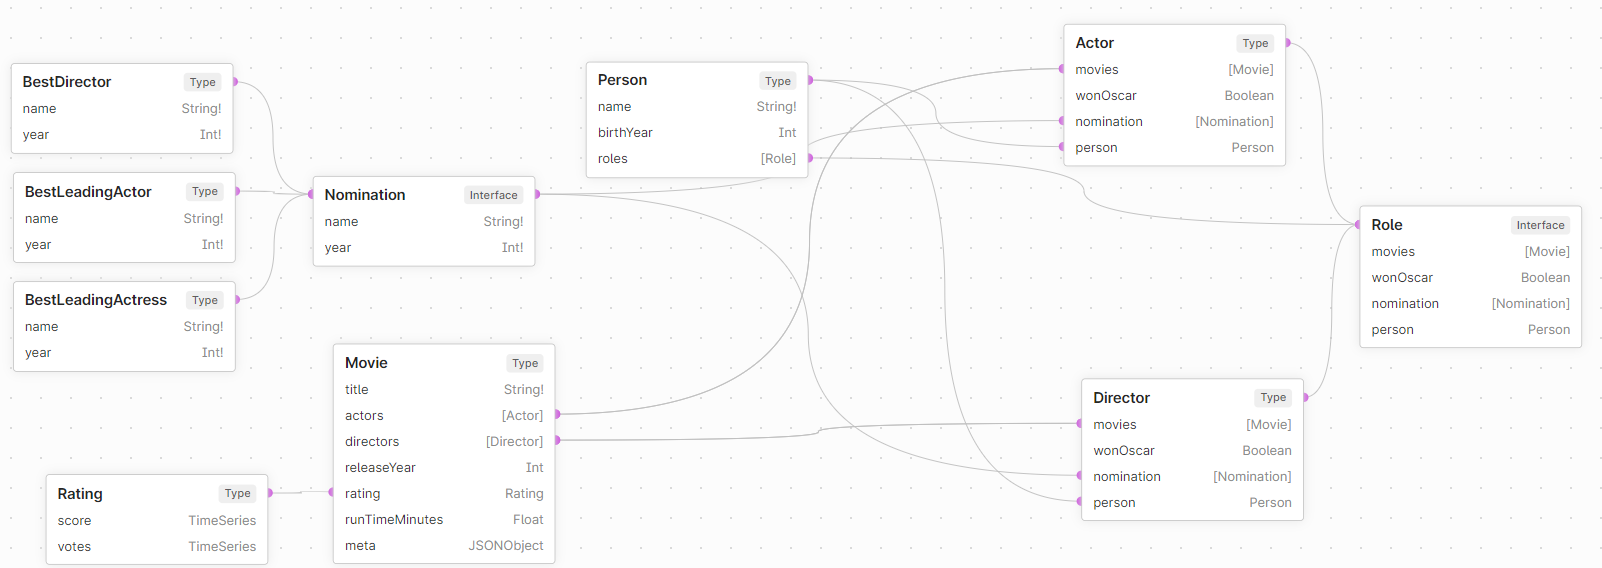g)

The goal of the first version is to get the same functionality as classic CDF such as assets, timeseries, events, i.e., using the CRUD operations for each of the types in the data model.

My thinking is to build this on the DMS API (at least the Delete and Apply methods), and then later extend it to include more advanced queries. 

In [1]:
from sdk.local import MovieClientLocal
from sdk import MovieClient
from data.load import load
from sdk.list_data_classes import ActorList, DirectorList
from IPython.display import display

In [2]:
# This is a local client, it is made for demo purposes. 
client = MovieClientLocal(load(), MovieClient())

## Listing Nodes

We use a parameter *propagation_limit* to control how many traversals we do in the graph. Default value is 0. This means none of the direct or one to many 
relationships are fetched.

In [3]:
movies_0 = client.movies.list()
movies_0

MovieList([Movie(external_id='movie:12_angry_men', title='12 Angry Men', release_year=1957, run_time_minutes=96.0, meta=None),
           Movie(external_id='movie:django_unchained', title='Django Unchained', release_year=2012, run_time_minutes=165.0, meta=None),
           Movie(external_id='movie:fargo', title='Fargo', release_year=1996, run_time_minutes=98.0, meta=None),
           Movie(external_id='movie:gladiator', title='Gladiator', release_year=2000, run_time_minutes=155.0, meta=None),
           Movie(external_id='movie:inglourious_basterds', title='Inglourious Basterds', release_year=2009, run_time_minutes=153.0, meta=None),
           Movie(external_id='movie:pulp_fiction', title='Pulp Fiction', release_year=1994, run_time_minutes=154.0, meta=None),
           Movie(external_id='movie:reservoir_dogs', title='Reservoir Dogs', release_year=1992, run_time_minutes=99.0, meta=None)])

In [4]:
# On level 0, we only have the external ids to the nodes one step away
pulp_fiction = movies_0[5]
pulp_fiction.actors is None

True

In [5]:
# On level 1, we also fetch the nodes one step away
movies_1 = client.movies.list(propagation_limit=1)

In [6]:
# For this case it means that we can access all the actors, directors, or rating of each of the movies
pulp_fiction = movies_1[5]
pulp_fiction.actors

[Actor(external_id='actor:quentin_tarantino', won_oscar=False),
 Actor(external_id='actor:samuel_l._jackson', won_oscar=True),
 Actor(external_id='actor:john_travolta', won_oscar=True),
 Actor(external_id='actor:harvey_keitel', won_oscar=False)]

In [7]:
# On level 2, we fetch nodes two steps away
movies_2 = client.movies.list(propagation_limit=2)

In [8]:
pulp_fiction = movies_2[5]
DirectorList(pulp_fiction.directors)

DirectorList([Director(external_id='director:quentin_tarantino', won_oscar=True, movies=['movie:django_unchained', 'movie:inglourious_basterds', 'movie:pulp_fiction', 'movie:reservoir_dogs'], person='person:quentin_tarantino', nomination=['director:quentin_tarantino:inglourious_basterds', 'director:quentin_tarantino:pulp_fiction'])])

In [9]:
# This means that we can select the director of a movie, and then display the person connected to that director.
tarantino_director = pulp_fiction.directors[0]
tarantino_director.person.name

'Quentin Tarantino'

In [10]:
ActorList(pulp_fiction.actors)

ActorList([Actor(external_id='actor:quentin_tarantino', won_oscar=False, movies=['movie:django_unchained', 'movie:inglourious_basterds', 'movie:pulp_fiction', 'movie:reservoir_dogs'], person='person:quentin_tarantino', nomination=['director:quentin_tarantino:inglourious_basterds', 'director:quentin_tarantino:pulp_fiction']),
           Actor(external_id='actor:samuel_l._jackson', won_oscar=True, movies=['movie:django_unchained', 'movie:pulp_fiction'], person='person:samuel_l._jackson', nomination=[]),
           Actor(external_id='actor:john_travolta', won_oscar=True, movies=['movie:pulp_fiction'], person='person:john_travolta', nomination=['leadingactor:john_travolta:pulp_fiction']),
           Actor(external_id='actor:harvey_keitel', won_oscar=False, movies=['movie:pulp_fiction', 'movie:reservoir_dogs'], person='person:harvey_keitel', nomination=[])])

In [11]:
john_travolta_actor = pulp_fiction.actors[2]

john_travolta_actor.person.name, john_travolta_actor.person.birth_year

('John Travolta', 1954)

## Retrieve

Retrieve works similary in that you can conrol how many recursive calls you do.

In [12]:
quentin = client.persons.retrieve(external_id="person:quentin_tarantino", propagation_limit=0)

In [13]:
quentin

Person(external_id='person:quentin_tarantino', name='Quentin Tarantino', birth_year=1963)

In [14]:
quentin.roles is None

True

In [15]:
quentin2 = client.persons.retrieve(external_id="person:quentin_tarantino", propagation_limit=2)

In [16]:
quentin2

Person(external_id='person:quentin_tarantino', name='Quentin Tarantino', birth_year=1963, roles=['actor:quentin_tarantino', 'director:quentin_tarantino'])

In [17]:
quentin2.roles[1].movies

[Movie(external_id='movie:django_unchained', title='Django Unchained', release_year=2012, run_time_minutes=165.0, meta=None),
 Movie(external_id='movie:inglourious_basterds', title='Inglourious Basterds', release_year=2009, run_time_minutes=153.0, meta=None),
 Movie(external_id='movie:pulp_fiction', title='Pulp Fiction', release_year=1994, run_time_minutes=154.0, meta=None),
 Movie(external_id='movie:reservoir_dogs', title='Reservoir Dogs', release_year=1992, run_time_minutes=99.0, meta=None)]

In [18]:
# Setting the propagation limit to -1 essentially fetches all nodes connected to Quentin.
quentin_full = client.persons.retrieve(external_id="person:quentin_tarantino", propagation_limit=-1)

In [19]:
quentin_full.roles[1].movies[0].actors

[Actor(external_id='actor:quentin_tarantino', movies=['movie:django_unchained', 'movie:inglourious_basterds', 'movie:pulp_fiction', 'movie:reservoir_dogs'], won_oscar=False, nomination=['director:quentin_tarantino:inglourious_basterds', 'director:quentin_tarantino:pulp_fiction'], person='person:quentin_tarantino'),
 Actor(external_id='actor:jamie_foxx', movies=['movie:django_unchained'], won_oscar=True, nomination=[], person='person:jamie_foxx'),
 Actor(external_id='actor:christoph_waltz', movies=['movie:django_unchained', 'movie:inglourious_basterds'], won_oscar=True, nomination=[], person='person:christoph_waltz'),
 Actor(external_id='actor:samuel_l._jackson', movies=['movie:django_unchained', 'movie:pulp_fiction'], won_oscar=True, nomination=[], person='person:samuel_l._jackson')]

In [20]:
quentin_full.roles[1].movies[0].actors[2].person.name

'Christoph Waltz'

##  Apply and Delete

In [21]:
from sdk.data_classes import Movie, Actor, Director

In [22]:
quentin_actor = client.actors.retrieve("actor:quentin_tarantino")

In [23]:
quentin_director = client.directors.retrieve("director:quentin_tarantino")

In [24]:
samuel_actor = client.actors.retrieve("actor:samuel_l._jackson")

In [25]:
hatefull_eight = Movie(title="The Hateful Eight", release_year=2015, run_time_minutes=168, actors=[quentin_actor, samuel_actor], directors=[quentin_director], external_id="movie:the_hatefull_eight")

In [26]:
client.movies.apply(hatefull_eight, propagation_limit=1)

Created/Updated node movie:the_hatefull_eight to graph and all nodes 1 step away.


In [27]:
client.movies.delete(hatefull_eight, propagation_limit=0)

Deleted node movie:the_hatefull_eight from graph and all nodes 0 step away.


## Remarks

Note that the concept of edge is abstracted away from the user. This means that the SDK will have to assume naming of external ids. 